# Analysis of FBI Supplemental Homicide Report Data 

In [1]:
import os
import sqlite3
import numpy as np
import pandas as pd
from utils import nb_run_from_command


## Data Import

In [2]:
# step backwards if notebook is being run interactively
# or stay put if being run from command line
if nb_run_from_command():
    os.chdir("..")


In [3]:
read_sql = lambda query, con: pd.read_sql(query, con).replace({"": np.NaN, "U": np.NaN})

with sqlite3.connect("input/sqlite__temp.db") as con:
    incidents = read_sql(
        """
        SELECT * FROM data_shrincidents;
        """,
        con,
    )
    offenders = read_sql(
        """
        SELECT * FROM data_shroffenders;
        """,
        con,
    )
    victims = read_sql(
        """
        SELECT * FROM data_shrvictims;
        """,
        con,
    )
    agencies = read_sql(
        """
        SELECT * FROM data_agencies;
        """,
        con,
    )


### Data Preparation

In [4]:
# standard columns used to reduce offender and victim data to one row per incident
GB_COLS = ["incident_id", "ori_code", "year"]


Get a dataframe containing one row per incident and columns indicating which offender information was reported

In [5]:
gb = offenders.groupby(GB_COLS)

join_args = {"how": "left"}

get_offender_info = lambda field: (
    gb[field]
    .apply(lambda vals: any(pd.notna(a) for a in vals))
    .to_frame(f"{field}_reported")
)

offender_info = (
    get_offender_info("offender_age")
    .join(get_offender_info("offender_sex"), **join_args)
    .join(get_offender_info("offender_race"), **join_args)
    .assign(any_offender_info=lambda df: df.any(axis=1))
    .assign(all_offender_info=lambda df: df.all(axis=1))
)

offender_info


,,,offender_age_reported,offender_sex_reported,offender_race_reported,any_offender_info,all_offender_info
incident_id,ori_code,year,,,,,
00001dd6fa45f7ba044bd5d84937be464ce78ac2,PAPEP0000,1995,True,True,True,True,True
0000296564272665ccd2925d377e124f3306b01e,INIPD0000,2004,False,False,False,False,False
000055d41c8a62052dd426592e8a4a3342bf565d,TX2260100,2020,True,True,True,True,True
0000b76d2145d9445d9ff6b65c9ebc4196c89337,GAAPD0000,2007,False,False,False,False,False
00010f65a5340264303727655cc554fdfd0da8f2,PA0022800,2001,True,True,True,True,True
...,...,...,...,...,...,...,...
fffe9c57a9b25623ac219260c1b5155087a788e9,TN0750100,2009,True,True,True,True,True
fffee86a5a0ce70dab14272b3924c41074fb1c61,GA0630100,2008,False,False,False,False,False
fffee88a3e3859d763c7b8f527745155abbb54ac,NY0303000,2011,False,False,False,False,False


Get a dataframe containing one row per incident with victim demographic data included

In [6]:
victims.victim_race.unique()


array(['B', 'W', 'A', 'I', nan, 'P'], dtype=object)

In [7]:
victim_info = (
    victims.groupby(GB_COLS)
    .victim_race.apply(
        lambda vals: "white only"
        if all(v == "W" for v in vals)
        else "black only"
        if all(v == "B" for v in vals)
        else "mixed white and black"
        if any(v == "W" for v in vals) and any(v == "B" for v in vals)
        else "other"
    )
    .to_frame("race_category")
)

victim_info


,,,race_category
incident_id,ori_code,year,
00001dd6fa45f7ba044bd5d84937be464ce78ac2,PAPEP0000,1995,black only
0000296564272665ccd2925d377e124f3306b01e,INIPD0000,2004,white only
000055d41c8a62052dd426592e8a4a3342bf565d,TX2260100,2020,white only
0000b76d2145d9445d9ff6b65c9ebc4196c89337,GAAPD0000,2007,black only
00010f65a5340264303727655cc554fdfd0da8f2,PA0022800,2001,white only
...,...,...,...
fffe9c57a9b25623ac219260c1b5155087a788e9,TN0750100,2009,black only
fffee86a5a0ce70dab14272b3924c41074fb1c61,GA0630100,2008,white only
fffee88a3e3859d763c7b8f527745155abbb54ac,NY0303000,2011,black only


### Availability of offender demographic information

In [8]:
def get_demo_crosstab(field):
    def to_multiindex(df):
        df.columns = pd.MultiIndex.from_tuples([(field, c) for c in df.columns])
        return df

    return (
        pd.crosstab(
            index=offender_info.index.get_level_values("year"),
            columns=[
                offender_info[field],
            ],
        )
        .assign(pct_reported=lambda df: df[True] / (df[False] + df[True]))
        .pipe(to_multiindex)
    )


(
    get_demo_crosstab("offender_sex_reported")
    .join(get_demo_crosstab("offender_race_reported"))
    .join(get_demo_crosstab("offender_age_reported"))
    .join(get_demo_crosstab("any_offender_info"))
    .join(get_demo_crosstab("all_offender_info"))
)


offender_sex_reported                     offender_race_reported         \
                      False   True pct_reported                  False   True   
row_0                                                                           
1995                   6501  13598     0.676551                   6707  13392   
1996                   5342  11712     0.686760                   5488  11566   
1997                   5117  10812     0.678762                   5263  10666   
1998                   4315   9998     0.698526                   4448   9865   
1999                   3973   9013     0.694055                   4103   8883   
2000                   4093   9127     0.690393                   4200   9020   
2001                   4307   9839     0.695532                   4528   9618   
2002                   4420   9832     0.689868                   4562   9690   
2003                   4643   9778     0.678039                   4772   9649   
2004                   4495   9788     0.685290                   4615   9668   
2005                   4565  10309     0.693089                   4741  10133   
2006                   4637  10439     0.692425                   4768  10308   
2007                   4785  10192     0.680510                   4932  10045   
2008                   4459   9877     0.688965                   4610   9726   
2009                   4091   9767     0.704791                   4211   9647   
2010                   3952   9348     0.702857                   4087   9213   
2011                   3829   9058     0.702879                   3941   8946   
2012                   3978   9090     0.695592                   4086   8982   
2013                   3834   8712     0.694405                   3935   8611   
2014                   3841   8691     0.693505                   3951   8581   
2015                   4459   9385     0.677911                   4591   9253   
2016                   5198  10133     0.660948                   5364   9967   
2017                   4953  10721     0.683999                   5135  10539   
2018                   4422  10502     0.703699                   4594  10330   
2019                   4387  10207     0.699397                   4582  10012   
2020                   5929  12535     0.678889                   6183  12281   

                   offender_age_reported                      \
      pct_reported                 False   True pct_reported   
row_0                                                          
1995      0.666302                  7482  12617     0.627743   
1996      0.678199                  6157  10897     0.638970   
1997      0.669596                  5909  10020     0.629041   
1998      0.689234                  5061   9252     0.646405   
1999      0.684044                  4625   8361     0.643847   
2000      0.682300                  4797   8423     0.637141   
2001      0.679910                  5176   8970     0.634102   
2002      0.679905                  5208   9044     0.634578   
2003      0.669094                  5539   8882     0.615907   
2004      0.676889                  5310   8973     0.628229   
2005      0.681256                  5325   9549     0.641993   
2006      0.683736                  5324   9752     0.646856   
2007      0.670695                  5445   9532     0.636443   
2008      0.678432                  5041   9295     0.648368   
2009      0.696132                  4645   9213     0.664815   
2010      0.692707                  4467   8833     0.664135   
2011      0.694188                  4354   8533     0.662140   
2012      0.687328                  4489   8579     0.656489   
2013      0.686354                  4266   8280     0.659971   
2014      0.684727                  4152   8380     0.668688   
2015      0.668376                  4847   8997     0.649884   
2016      0.650121                  5597   9734     0.634923   
2017      0.672387                  5338  10336     0.65

In [9]:
# single dataframe from which we'll do all analysis
df = (
    incidents.rename(columns={"incident_unique_id": "incident_id"})
    .set_index(GB_COLS)
    .join(offender_info)
    .join(victim_info)
    .reset_index()
)

df


,incident_id,ori_code,year,last_update,homicide,situation,offender_age_reported,offender_sex_reported,offender_race_reported,any_offender_info,all_offender_info,race_category
0,b6589fc6ab0dc82cf12099d1c2d40ab994e8410c,AK0010100,2020,2021-09-30,A,A,True,True,True,True,True,other
1,356a192b7913b04c54574d18c28d46e6395428ab,AK0010100,2020,2021-09-30,A,C,True,True,True,True,True,black only
2,da4b9237bacccdf19c0760cab7aec4a8359010b0,AK0010100,2020,2021-09-30,A,A,True,True,True,True,True,white only
3,77de68daecd823babbb58edb1c8e14d7106e83bb,AK0010100,2020,2021-09-30,A,A,True,True,True,True,True,other
4,1b6453892473a467d07372d45eb05abc2031647a,AK0010100,2020,2021-09-30,A,A,True,True,True,True,True,other
...,...,...,...,...,...,...,...,...,...,...,...,...
380983,27f057b7644a9e3a59e579325d91dd5be2b8406a,HI0040000,2005,2005-07-25,A,A,True,True,True,True,True,white only
380984,ae0906ac7c4d9a67e29455bc1f16bac9a05bfcbd,HI0040000,2005,2005-08-17,A,A,True,True,True,True,True,white only
380985,ea8990941c60eb553983d700ad9d41bebd7283e0,HI0050000,2005,2005-08-05,A,B,False,False,False,False,False,black only
380986,1bb31a3533794756fc6cb271898a9ce93526f256,HI0050000,2005,2005-09-22,A,A,True,True,True,True,True,white only


## Analysis

### National

Nationally, the rate of offender demographics reported is substantially lower for homicides with Black victims than it is with white victims. In 2020, less than 60% of cases had offender demographic data present, compared to bout 80% for white victims

In [10]:
def get_demo_pcts(df):
    for race in df.columns.get_level_values("race_category"):
        df[(race, "offender_info_reported")] = df[(race, True)] / (
            df[(race, False)] + df[(race, True)]
        )
    return df


national = pd.crosstab(
    index=df.year, columns=[df.race_category, df.any_offender_info]
).pipe(get_demo_pcts)

national.to_csv("output/national.csv")

national


race_category     black only       mixed white and black      other       \
any_offender_info      False  True                 False True False True   
year                                                                       
1995                    3491  6255                    14   35   250  457   
1996                    2899  5347                    14   24   204  392   
1997                    2802  4940                     9   17   230  409   
1998                    2317  4381                    14   19   197  354   
1999                    2096  3914                     8   15   153  328   
2000                    2301  3992                     4   15   159  354   
2001                    2364  4227                     4   15   183  371   
2002                    2528  4267                    12   21   174  408   
2003                    2588  4288                     7   35   199  395   
2004                    2448  4175                    12   21   192  372   
2005                    2550  4544                    15   24   192  416   
2006                    2660  4747                     7   22   185  415   
2007                    2710  4651                     8   32   195  380   
2008                    2543  4274                    16   21   171  397   
2009                    2395  4218                    16   29   133  372   
2010                    2450  4150                    15   22   122  365   
2011                    2408  4022                    10   22   127  380   
2012                    2554  4026                    12   28   109  380   
2013                    2470  3833                    11   36   110  355   
2014                    2476  3781                     8   13   139  342   
2015                    2984  4182                    11   46   146  430   
2016                    3452  4452                    16   39   163  470   
2017                    3213  4664                    24   49   188  557   
2018                    2957  4588                    12   49   149  565   
2019                    3022  4546                    16   47   139  559   
2020                    4054  5861                    23   61   204  712   

race_category     white only                   black only  \
any_offender_info      False  True offender_info_reported   
year                                                        
1995                    2736  6861               0.641802   
1996                    2220  5954               0.648436   
1997                    2067  5455               0.638078   
1998                    1781  5250               0.654076   
1999                    1709  4763               0.651248   
2000                    1624  4771               0.634356   
2001                    1744  5238               0.641329   
2002                    1686  5156               0.627962   
2003                    1836  5073               0.623618   
2004                    1826  5237               0.630379   
2005                    1780  5353               0.640541   
2006                    1751  5289               0.640880   
2007                    1846  5155               0.631843   
2008                    1688  5226               0.626962   
2009                    1523  5172               0.637835   
2010                    1354  4822               0.628788   
2011                    1249  4669               0.625505   
2012                    1272  4687               0.611854   
2013                    1215  4516               0.608123   
2014                    1186  4587               0.604283   
2015                    1299  4746               0.583589   
2016                    1542  5197               0.563259   
2017                    1486  5493               0.592104   
2018                    1263  5341               0.608085   
2019                    1148  5117               0.600687   
2020                    1546  6003               0.591125   

race_category      mixed 

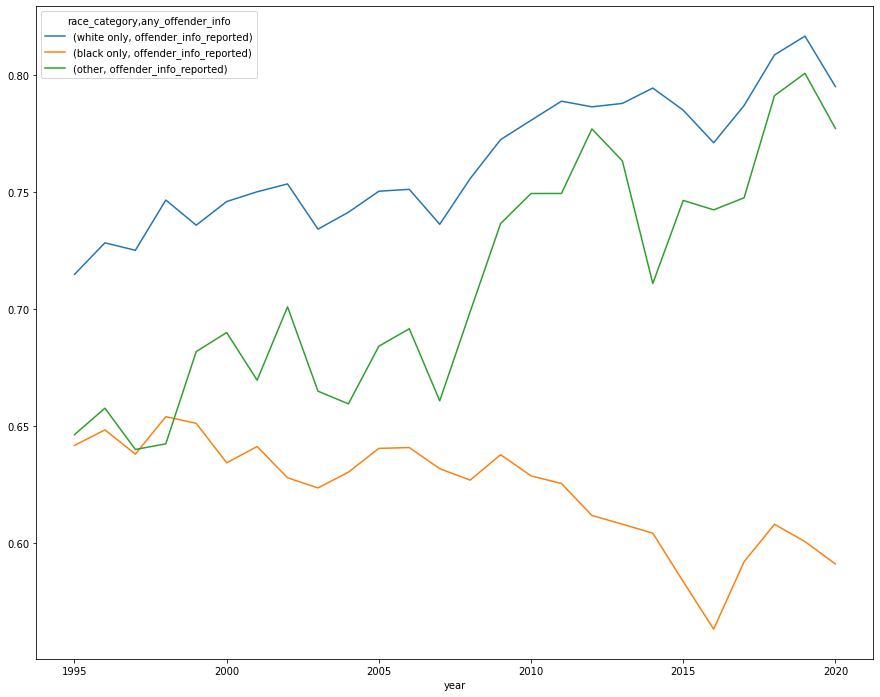

In [12]:
(
    national[
        [
            ("white only", "offender_info_reported"),
            ("black only", "offender_info_reported"),
            ("other", "offender_info_reported"),
        ]
    ]
    .plot(figsize=(15, 12))
    .get_figure()
    .savefig("output/black_vs_white_national.svg")
)
